## Optimization

In [1]:
#import libraries
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import math
import sklearn
import sklearn.datasets

from opt_utils import load_params_and_grads, initialize_parameters, forward_propagation, backward_propagation
from opt_utils import compute_cost, predict, predict_dec, plot_decision_boundary, load_dataset

%matplotlib inline
plt.rcParams['figure.figsize'] = (7.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

### 1. Gradient Descent

In [16]:
def update_parameters_with_gd(parameters, grads, learning_rate):
    L = len(parameters)//2
    for l in range(L):
        parameters["W"+str(l+1)] -= learning_rate*grads["dW"+str(l+1)]
        parameters["b"+str(l+1)] -= learning_rate*grads["db"+str(l+1)]
    return parameters

### 2. Mini-Batch Gradient Descent

In [14]:
#build mini-batches
def random_mini_batches(X, Y, batch_size=64, seed=0):
    np.random.seed(seed)
    m = X.shape[1]
    mini_batches = []
    
    #shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((1,m))
    
    #partition
    num_complete_minibatches = math.floor(m/batch_size)
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[:,k*batch_size:(k+1)*batch_size]
        mini_batch_Y = shuffled_Y[:,k*batch_size:(k+1)*batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
        
    if m%batch_size!=0:
        mini_batch_X = shuffled_X[:,num_complete_minibatches*batch_size:]
        mini_batch_Y = shuffled_Y[:,num_complete_minibatches*batch_size:]
        mini_batch = (mini_batch_X,mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

### 3. Momentum

In [5]:
def initialize_velocity(parameters):
    L = len(parameters)//2
    V = {}
    for l in range(L):
        V["dW"+str(l+1)] = np.zeros(parameters["W"+str(l+1)].shape)
        V["db"+str(l+1)] = np.zeros(parameters["b"+str(l+1)].shape)
    return V

In [6]:
def update_parameters_with_momentum(parameters, grads, v, beta, learning_rate):
    L = len(parameters)//2
    for l in range(L):
        v["dW"+str(l+1)] = beta*v["dW"+str(l+1)] + (1-beta)*(grads["dW"+str(l+1)])
        v["db"+str(l+1)] = beta*v["db"+str(l+1)] + (1-beta)*(grads["db"+str(l+1)])
        
        parameters["W"+str(l+1)] -= learning_rate*v["dW"+str(l+1)]
        parameters["b"+str(l+1)] -= learning_rate*v["db"+str(l+1)]
    
    return parameters, v

### 4. Adam

In [7]:
def initialize_adam(parameters):
    L = len(parameters)//2
    V = {}
    S = {}
    for l in range(L):
        V["dW"+str(l+1)] = np.zeros(parameters["W"+str(l+1)].shape)
        V["db"+str(l+1)] = np.zeros(parameters["b"+str(l+1)].shape)
        S["dW"+str(l+1)] = np.zeros(parameters["W"+str(l+1)].shape)
        S["db"+str(l+1)] = np.zeros(parameters["b"+str(l+1)].shape)
        
    return V, S

In [37]:
def update_parameters_with_adam(parameters, grads, v, s, t, learning_rate=0.01, 
                               beta1=0.9, beta2=0.999, epsilon=1e-8):
    L = len(parameters)//2
    s_corrected = {}
    v_corrected = {}
    
    for l in range(L):
        v["dW"+str(l+1)] = beta1*v["dW"+str(l+1)] + (1-beta1)*(grads["dW"+str(l+1)])
        v["db"+str(l+1)] = beta1*v["db"+str(l+1)] + (1-beta1)*(grads["db"+str(l+1)])
        
        v_corrected["dW"+str(l+1)] = v["dW"+str(l+1)]/(1-np.power(beta1,t))
        v_corrected["db"+str(l+1)] = v["db"+str(l+1)]/(1-np.power(beta1,t))
        
        s["dW" + str(l+1)] = beta2*(s["dW" + str(l+1)]) + (1-beta2)*np.power(grads["dW"+str(l+1)],2)
        s["db" + str(l+1)] = beta2*(s["db" + str(l+1)]) + (1-beta2)*np.power(grads["db"+str(l+1)],2)
        
        s_corrected["dW" + str(l+1)] = s["dW" + str(l+1)]/(1-np.power(beta2,t))
        s_corrected["db" + str(l+1)] = s["db" + str(l+1)]/(1-np.power(beta2,t))
        
        parameters["W" + str(l+1)] -= learning_rate * \
                            (v_corrected["dW"+str(l+1)]/(np.sqrt(s_corrected["dW"+str(l+1)]+epsilon))) 
        parameters["b" + str(l+1)] -= learning_rate * \
                            (v_corrected["db"+str(l+1)]/(np.sqrt(s_corrected["db"+str(l+1)]+epsilon)))  
            
    return parameters, v, s
        
        

### 5. Model with different algorithms

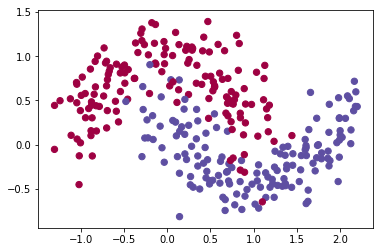

In [11]:
train_X, train_Y = load_dataset()

In [39]:
def model(X, Y, layer_dims, optimizer, learning_rate=0.0007, mini_batch_size=64, beta=0.9,
         beta1=0.9, beta2=0.09, epsilon=1e-8, num_epochs=10000, print_cost=True):
    L = len(layer_dims)
    costs = []
    t = 0
    seed = 10
    
    #initialize the parameters
    parameters = initialize_parameters(layer_dims)
    
    #initialize the optimizer
    if optimizer=="gd":
        pass
    elif optimizer=="momentum":
        v = initialize_velocity(parameters)
    elif optimizer=="adam":
        v, s = initialize_adam(parameters)
        
    #optimization loop
    for i in range(num_epochs):
        seed = seed + 1
        minibatches = random_mini_batches(X, Y, mini_batch_size, seed)
        
        for minibatch in minibatches:
            (minibatch_X, minibatch_Y) = minibatch
            
            #forward_propagation
            a3, caches = forward_propagation(minibatch_X, parameters)
            
            #compute cost
            cost = compute_cost(a3, minibatch_Y)
            
            #backward_propagation
            grads = backward_propagation(minibatch_X, minibatch_Y, caches)
            
            #update the parameters
            if optimizer=="gd":
                parameters = update_parameters_with_gd(parameters, grads, learning_rate)
            elif optimizer=="momentum":
                parameters,v = update_parameters_with_momentum(parameters, grads, v, beta, learning_rate)
            elif optimizer=="adam":
                t += 1 
                parameters,v,s = update_parameters_with_adam(parameters, grads, v, s, t, 
                                                         learning_rate, beta1, beta2, epsilon)
                
        if print_cost and i % 1000 == 0:
            print ("Cost after epoch %i: %f" %(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
    
    # plot the cost
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('epochs (per 100)')
    plt.title("Learning rate = " + str(learning_rate))
    plt.show()
    
    return parameters
            
    

#### 5.1 : mini-batch gradient descent

Cost after epoch 0: 0.690736
Cost after epoch 1000: 0.685273
Cost after epoch 2000: 0.647072
Cost after epoch 3000: 0.619525
Cost after epoch 4000: 0.576584
Cost after epoch 5000: 0.607243
Cost after epoch 6000: 0.529403
Cost after epoch 7000: 0.460768
Cost after epoch 8000: 0.465586
Cost after epoch 9000: 0.464518


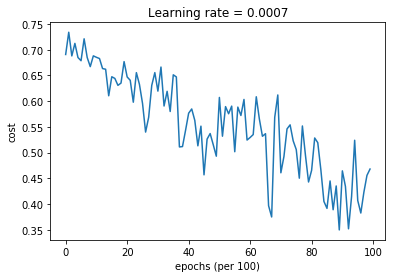

Accuracy: 0.7966666666666666


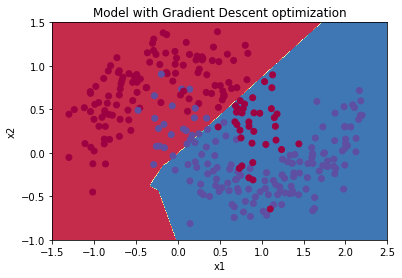

In [17]:
# train 3-layer model
layers_dims = [train_X.shape[0], 5, 2, 1]
parameters = model(train_X, train_Y, layers_dims, optimizer = "gd")

# Predict
predictions = predict(train_X, train_Y, parameters)

# Plot decision boundary
plt.title("Model with Gradient Descent optimization")
axes = plt.gca()
axes.set_xlim([-1.5,2.5])
axes.set_ylim([-1,1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

#### 5.2 : mini batch gradient descent with momentum

Cost after epoch 0: 0.690741
Cost after epoch 1000: 0.685341
Cost after epoch 2000: 0.647145
Cost after epoch 3000: 0.619594
Cost after epoch 4000: 0.576665
Cost after epoch 5000: 0.607324
Cost after epoch 6000: 0.529476
Cost after epoch 7000: 0.460936
Cost after epoch 8000: 0.465780
Cost after epoch 9000: 0.464740


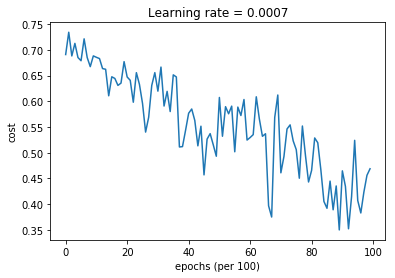

Accuracy: 0.7966666666666666


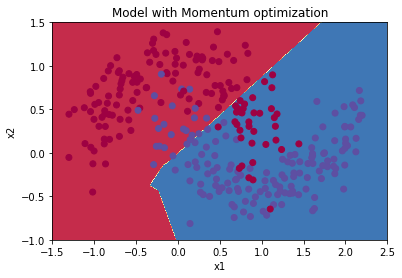

In [35]:
# train 3-layer model
layers_dims = [train_X.shape[0], 5, 2, 1]
parameters = model(train_X, train_Y, layers_dims, beta = 0.9, optimizer = "momentum")

# Predict
predictions = predict(train_X, train_Y, parameters)

# Plot decision boundary
plt.title("Model with Momentum optimization")
axes = plt.gca()
axes.set_xlim([-1.5,2.5])
axes.set_ylim([-1,1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

#### 5.3 : mini batch gradient descent with adam

Cost after epoch 0: 0.690466
Cost after epoch 1000: 0.151044
Cost after epoch 2000: 0.133562
Cost after epoch 3000: 0.070386
Cost after epoch 4000: 0.121355
Cost after epoch 5000: 0.091318
Cost after epoch 6000: 0.079878
Cost after epoch 7000: 0.030352
Cost after epoch 8000: 0.112425
Cost after epoch 9000: 0.201232


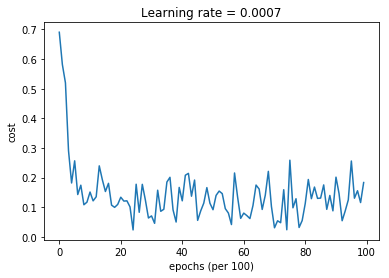

Accuracy: 0.9433333333333334


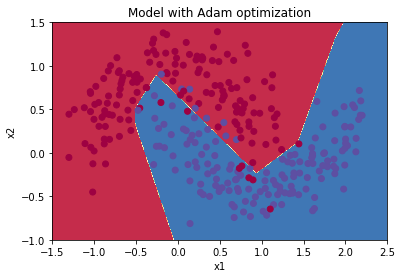

In [40]:
# train 3-layer model
layers_dims = [train_X.shape[0], 5, 2, 1]
parameters = model(train_X, train_Y, layers_dims, optimizer="adam")

# Predict
predictions = predict(train_X, train_Y, parameters)

# Plot decision boundary
plt.title("Model with Adam optimization")
axes = plt.gca()
axes.set_xlim([-1.5,2.5])
axes.set_ylim([-1,1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

Momentum usually helps, but given the small learning rate and the simplistic dataset, its impact is almost negligeable. Also, the huge oscillations you see in the cost come from the fact that some minibatches are more difficult thans others for the optimization algorithm.

Adam on the other hand, clearly outperforms mini-batch gradient descent and Momentum. If you run the model for more epochs on this simple dataset, all three methods will lead to very good results. However, you've seen that Adam converges a lot faster.

Some advantages of Adam include:

- Relatively low memory requirements (though higher than gradient descent and gradient descent with momentum)
- Usually works well even with little tuning of hyperparameters (except αα)
